# Theory





## Libraries

In [1]:
import numpy as np
from statsmodels import distributions
from scipy.optimize import fsolve
from scipy import stats
from operator import sub
import math
import matplotlib.pyplot as plt
import pandas as pd

## Read data

In [2]:
df = pd.read_csv('RDS_GDM_CC_INPUT.csv', sep=';')
df

,Posicao,DTPOSICAO,I_Est_Def12m_PES_FINAL,Rating_Final_Corrected,Score_Corrected,undrawn,R_ST,DES1,DES2,DES3,DES4,DES5,DES6
0,201012,31DEC2010:00:00:00,0,bb,6.21,Drawn,Unrated,1,1,0,0,0,bb
1,201012,31DEC2010:00:00:00,0,b,7.62,Undrawn,Unrated,1,0,0,0,0,b
2,201012,31DEC2010:00:00:00,1,ccc+,8.29,Drawn,Unrated,1,1,0,0,0,ccc+
3,201012,31DEC2010:00:00:00,0,bb+,5.96,Drawn,Unrated,1,1,0,0,0,bb+
4,201012,31DEC2010:00:00:00,0,a-,3.51,Undrawn,Unrated,1,0,0,0,0,a-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19594,202312,31DEC2023:00:00:00,0,b,7.74,Drawn,Unrated,1,1,0,0,0,b
19595,202312,31DEC2023:00:00:00,0,b+,7.44,Drawn,Unrated,1,1,0,0,0,b+
19596,202312,31DEC2023:00:00:00,0,MISSING,NaN,Drawn,Rated,0,1,1,0,1,MISSING
19597,202312,31DEC2023:00:00:00,0,MISSING,NaN,Drawn,Rated,0,1,1,0,1,MISSING


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19599 entries, 0 to 19598
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 19599 non-null  int64  
 1   DTPOSICAO               19599 non-null  object 
 2   I_Est_Def12m_PES_FINAL  19599 non-null  int64  
 3   Rating_Final_Corrected  19599 non-null  object 
 4   Score_Corrected         15936 non-null  float64
 5   undrawn                 19599 non-null  object 
 6   R_ST                    19599 non-null  object 
 7   DES1                    19599 non-null  int64  
 8   DES2                    19599 non-null  int64  
 9   DES3                    19599 non-null  int64  
 10  DES4                    19599 non-null  int64  
 11  DES5                    19599 non-null  int64  
 12  DES6                    19599 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usage: 1.9+ MB


# Function: prepare portfolio
Esta função:

Limpa os dados com nulos nas colunas essenciais.
Agrupa por score e calcula:
número total de contratos (count)
número de defaults (bads)
número de não-defaults (goods)
PD empírica condicional (pd_cnd) por score.
O dicionário retornado será é usado como input para modelar a relação entre score e PD.

In [4]:
def prepare_portfolio(df, rating_col, score_col, default_col):

    df_clean = df.dropna(subset=[rating_col, score_col, default_col])

    grp = df_clean.groupby(score_col).agg(count=(default_col, 'size'), bads=('I_Est_Def12m_PES_FINAL', 'sum')).sort_values(score_col, ascending=False)
    grp['goods'] = grp['count']-grp['bads']
    categories = grp.index.tolist()
    portfolio = grp['count'].values
    goods = grp['goods'].values
    pd_cnd = (df_clean.groupby(score_col)[default_col].mean().reindex(categories).tolist())

    return{'portfolio': tuple(portfolio), 'goods': tuple(goods), 'pd_cnd': pd_cnd, 'mapping': categories}

In [5]:
# ver output em dataframe
data = prepare_portfolio(df, 'Rating_Final_Corrected', 'Score_Corrected', 'I_Est_Def12m_PES_FINAL')

df_view = pd.DataFrame({
    "Rating": data['mapping'],
    "Portfolio": data['portfolio'],
    "Goods": data['goods'],
    "Bads": [p - g for p, g in zip(data['portfolio'], data['goods'])],
    "PD_cnd": data['pd_cnd']
})

df_view

,Rating,Portfolio,Goods,Bads,PD_cnd
0,10.00,42,23,19,0.452381
1,9.85,2,2,0,0.000000
2,9.67,1,1,0,0.000000
3,9.60,3,3,0,0.000000
4,9.58,15,12,3,0.200000
...,...,...,...,...,...
523,3.51,1,1,0,0.000000
524,3.50,57,57,0,0.000000
525,3.21,2,2,0,0.000000
526,3.07,2,2,0,0.000000


# Class LDP e QMM

In [6]:
class LDPortfolio:
    """
    Basic functionality for all LDP calibration facilities.
    :attribute self.ar: Estimated Accuracy ratio given portfolio distribution and PD values
    :attribute self.ct: Central Tendency (mean PD) ratio given portfolio distribution and PD values
    """
    def __init__(self, portfolio, goods, pd_cnd):
        """
        :param portfolio: Unconditional portfolio distribution from the worst to the best credit quality;

        :param pd_cnd: Current conditional PD distribution from the worst to the best credit quality. Could be used
                            for current AR estimation.
        """
        self.portfolio = np.array(portfolio)
        self.goods = np.array(goods)
        self.pd_cnd = np.array(pd_cnd)

        self.portfolio_size = self.portfolio.sum()
        self.portfolio_dist = self.portfolio.cumsum() / self.portfolio_size
        self.portfolio_dist = (np.hstack((0, self.portfolio_dist[:-1])) + self.portfolio_dist) / 2
        self.rating_prob = self.portfolio / self.portfolio_size

        self.goods_size = self.goods.sum()
        self.goods_dist = self.goods.cumsum() / self.goods_size
        self.goods_dist = (np.hstack((0, self.goods_dist[:-1])) + self.goods_dist) / 2
        self.goods_rating_prob = self.goods / self.goods_size

        self.ct = None
        self.ar = None
        if not pd_cnd is None:
            self.ct, self.ar = self._ar_estimate(self.pd_cnd)

    def _ar_estimate(self, pd_cnd):
        ct = self.rating_prob.T.dot(pd_cnd)
        ar_1int_1 = self.rating_prob * pd_cnd
        ar_1int_1 = np.hstack((0, ar_1int_1[:-1]))
        ar_1int_1 =  (1 - pd_cnd) * self.rating_prob * ar_1int_1.cumsum()
        ar_1 = 2 * ar_1int_1.sum()
        ar_2 =  (1 - pd_cnd) * pd_cnd * self.rating_prob * self.rating_prob
        ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
        return ct, ar.sum()



class QMM(LDPortfolio):
    """
    Calibrates conditional probabilities of default according to Quasi Moment Matching algorithm
    :attribute self.pd_cnd: calibrated conditional PD
    :attribute self.alpha: intercept calibration parameter
    :attribute self.beta: slope calibration parameter
    """
    def __init__(self, portfolio, goods, clb_curve = 'robust.logit', portfolio_cnd_no_dft = None):
        """
        :param portfolio: Unconditional portfolio distribution from the worst to the best credit quality;

        :param clb_curve: In case ’logit’, simple logit calibration curve is used (is applicable only for
                        rating_type = ’SCORE’). In case ’robust.logit’, robust logit function is used
                        (see Tasche D.(2013) for details).
        :param portfolio_cnd_no_dft: conditional on no default portfolio distribution (in case None, unconditional
                                    portfolio distribution is used as a proxy)
        :return: initialized QMM class object
        """

        super().__init__(portfolio, goods, pd_cnd=None)
        if portfolio_cnd_no_dft is None:
            self.portfolio_cnd_no_dft = self.goods
        else:
            self.portfolio_cnd_no_dft = self.portfolio_cnd_no_dft
        self.clb_curve = clb_curve
        self.alpha = None
        self.beta = None

    def fit(self, ct_target, ar_target):
        """
        :param ct_target: target Central Tendency
        :param ar_target: target Accuracy Ratio
        :return: calibrated QMM class
        """
        a = self.__get_pd((0, 0))
        tf = lambda x: tuple(map(sub, self._ar_estimate(self.__get_pd(x)), (ct_target, ar_target)))
        params = fsolve(tf, (0, 0))
        self.alpha, self.beta = params
        self.pd_cnd = self.__get_pd(params)
        self.ct, self.ar = self._ar_estimate(self.pd_cnd)
        return self

    def __get_pd(self, params):
        if self.clb_curve == 'logit':
            return self._logit(self.portfolio, params)
        else:
            return self._robust_logit(self.goods_dist, params)

    @staticmethod
    def _robust_logit(x, params):
        alpha, beta = params
        return 1 / (1 + np.exp(- alpha - beta * stats.norm.ppf(x)))

    @staticmethod
    def _logit(x, params):
        alpha, beta = params
        return 1 / (1 + np.exp(- alpha - beta * x))

# Run QMM

In [9]:
def run_QMM(output, df_input, LRADR_target, ar_target=None):

    # If ar_target is none, it considers the ar observed to the QMM
    info = prepare_portfolio(df_input, 'Rating_Final_Corrected', 'Score_Corrected', 'I_Est_Def12m_PES_FINAL')
    p1 = LDPortfolio(info['portfolio'], info['goods'], info['pd_cnd'])

    # Use provided AR target or fall back to observed
    target_ar = ar_target if ar_target is not None else p1.ar


    q1 = QMM(info['portfolio'], info['goods'])
    q1.fit(ct_target=LRADR_target, ar_target=target_ar) # can replace with own values as well but using observed values for illustrative purposes
    #print(q1.alpha)
    #print(q1.beta)

    observed_PD = info['pd_cnd']
    model_PD = q1.pd_cnd
    x_labels = info['mapping']

    ################################ PLOT ######################################

    # Cores Novo Banco
    verde_escuro = '#179297'
    verde_claro = 'pink'
    verde_medio = '#BFCE28'

    # Criar stilo de gráfico
    plt.figure(figsize=(12, 7))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot das linhas com cores Novo Banco
    plt.plot(x_labels, observed_PD,
            label='Observed PD',
            marker='o',
            color=verde_escuro,
            linewidth=2,
            markersize=6,
            markerfacecolor=verde_escuro,
            markeredgecolor='white',
            markeredgewidth=1)

    plt.plot(x_labels, model_PD,
            label='QMM Modeled PD',
            marker='s',
            color=verde_claro,
            linewidth=2,
            markersize=6,
            markerfacecolor=verde_claro,
            markeredgecolor='white',
            markeredgewidth=0,
            linestyle='--')

    # Área sombreada entre as curvas
    plt.fill_between(x_labels, observed_PD, model_PD,
                    alpha=0.15,
                    color=verde_medio)

    # Títulos e labels
    plt.xlabel('Credit Score', fontsize=13, fontweight='bold')
    plt.ylabel('Probability of Default', fontsize=13, fontweight='bold')
    plt.title('Observed vs QMM Modelled PD', fontsize=18, fontweight='bold', color=verde_escuro, pad=15)

    # Legenda estilizada
    plt.legend(frameon=True,
              fancybox=True,
              shadow=True,
              fontsize=11,
              loc='upper right')

    # Grid e formatação
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(fontsize=11)

    # Formato percentual no eixo Y
    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1%}'))

    plt.tight_layout()
    plt.show()

    print("\n\n********************* DATA QUALITY CHECKS *********************\n")

    display(df_input.info())
    print("\n---------------------------------------------------------------\n")

    df_input['Rating_Final_Corrected'].value_counts()
    # DROP DE MISSINGS OU NÃO ????????
    nan_counts = df_input[df_input['Rating_Final_Corrected'] == 'MISSING'].shape[0]
    print(f"Rating_Final_Corrected Nº MISSINGS: {nan_counts}\n")
    nan_countsx = int(df_input[['Score_Corrected']].isna().sum().values[0])
    print(f"Score_Corrected Nº MISSINGS: {nan_countsx}\n")


    ########################### RESULTS ########################################

    print("\n********************* RESULTS *******************************\n\n")

    print(f"Observed CT: {p1.ct:.5f},    Target CT: {LRADR_target:.5f},    Diff: {p1.ct - LRADR_target:.3f}")
    print(f"Observed AR: {p1.ar:.5f},    Target AR: {target_ar:.5f},    Diff: {p1.ar - target_ar:.3f}\n")

    print("-----------------------------------------------------------------\n")

    print(f"QMM model PD: {q1.ct}\n")
    print(f"Observed PD: {LRADR_target}\n")
    print(f"Alpha: {q1.alpha}\n")
    print(f"Beta: {q1.beta}\n")
    print(f"Rating Model AR: {p1.ar}\n")
    print(f"QMM Model AR: {q1.ar}\n")

    # Save results
    qmm_results = pd.DataFrame({'Score_Corrected':info['mapping'], 'QMM':q1.pd_cnd})
    qmm_results = pd.merge(df_input, qmm_results, on="Score_Corrected", how="left")
    # save excel
    qmm_results.to_excel(f'''{output}.xlsx''')

    results = qmm_results.groupby('Rating_Final_Corrected').agg(n_obs=('I_Est_Def12m_PES_FINAL', 'size'), DR =('I_Est_Def12m_PES_FINAL', 'mean'), QMM = ('QMM','mean'))
    results['DR_p'] = results['DR']*100
    results['QMM_p'] = results['QMM']*100

    print("\n\n**************** FINAL RESULTS **********************************\n")

    display(results)

    return qmm_results, results.sort_values(by='QMM')

# CHALLENGES RESULTS

*   Desafio 1 - Exclusão de todos os casos em que o máximo da exposição é 5000 euros
*   Desafio 2 - Considerar apenas exposição drawn
*   Desafio 3 - Considerar apenas clientes rated
*   Desafio 4 - Considerar apenas clientes rated e excluir todos os casos em que o máximo da exposição do cliente é 5000 euros
*   Desafio 5 - Considerar apenas clientes rated e drawn
*   Desafio 6 - Considerar apenas rating 12 meses antes do default














################### CHALLENGE DES1 ##########################


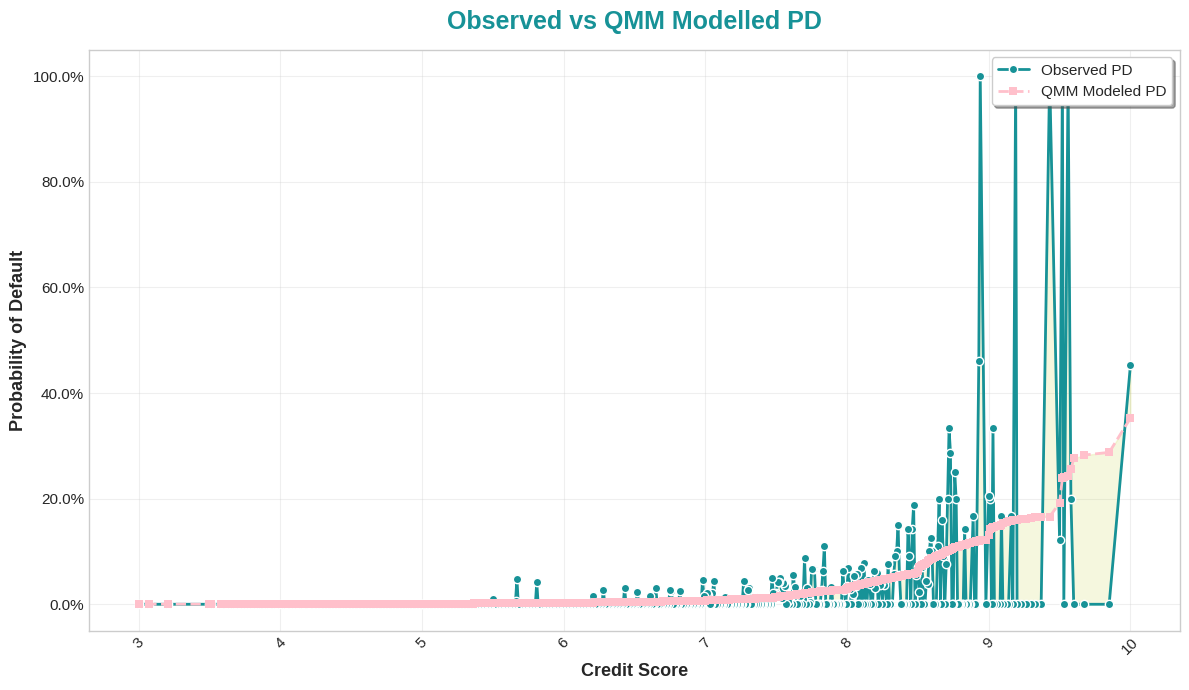



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 19134 entries, 0 to 19595
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 19134 non-null  int64  
 1   DTPOSICAO               19134 non-null  object 
 2   I_Est_Def12m_PES_FINAL  19134 non-null  int64  
 3   Rating_Final_Corrected  19134 non-null  object 
 4   Score_Corrected         15891 non-null  float64
 5   undrawn                 19134 non-null  object 
 6   R_ST                    19134 non-null  object 
 7   DES1                    19134 non-null  int64  
 8   DES2                    19134 non-null  int64  
 9   DES3                    19134 non-null  int64  
 10  DES4                    19134 non-null  int64  
 11  DES5                    19134 non-null  int64  
 12  DES6                    19134 non-null  object 
dtypes: float64(1), int64(7), obje

None


---------------------------------------------------------------

Rating_Final_Corrected Nº MISSINGS: 3243

Score_Corrected Nº MISSINGS: 3243


********************* RESULTS *******************************


Observed CT: 0.01718,    Target CT: 0.01770,    Diff: -0.001
Observed AR: 0.66102,    Target AR: 0.66102,    Diff: 0.000

-----------------------------------------------------------------

QMM model PD: 0.017704799671716925

Observed PD: 0.017704799672356556

Alpha: -4.931612105744964

Beta: -1.3596128280678588

Rating Model AR: 0.6610225263702016

QMM Model AR: 0.661022526369621



**************** FINAL RESULTS **********************************



,n_obs,DR,QMM,DR_p,QMM_p
Rating_Final_Corrected,,,,,
MISSING,3243,0.027752,NaN,2.775208,NaN
a,2,0.000000,0.000106,0.000000,0.010627
a+,14,0.000000,0.000078,0.000000,0.007815
a-,60,0.000000,0.000170,0.000000,0.017038
b,1785,0.019608,0.021677,1.960784,2.167747
b+,2759,0.012686,0.012235,1.268576,1.223544
b-,1162,0.035284,0.035847,3.528399,3.584720
bb,2242,0.003568,0.004259,0.356824,0.425904
bb+,2295,0.002614,0.002347,0.261438,0.234670





################### CHALLENGE DES2 ##########################


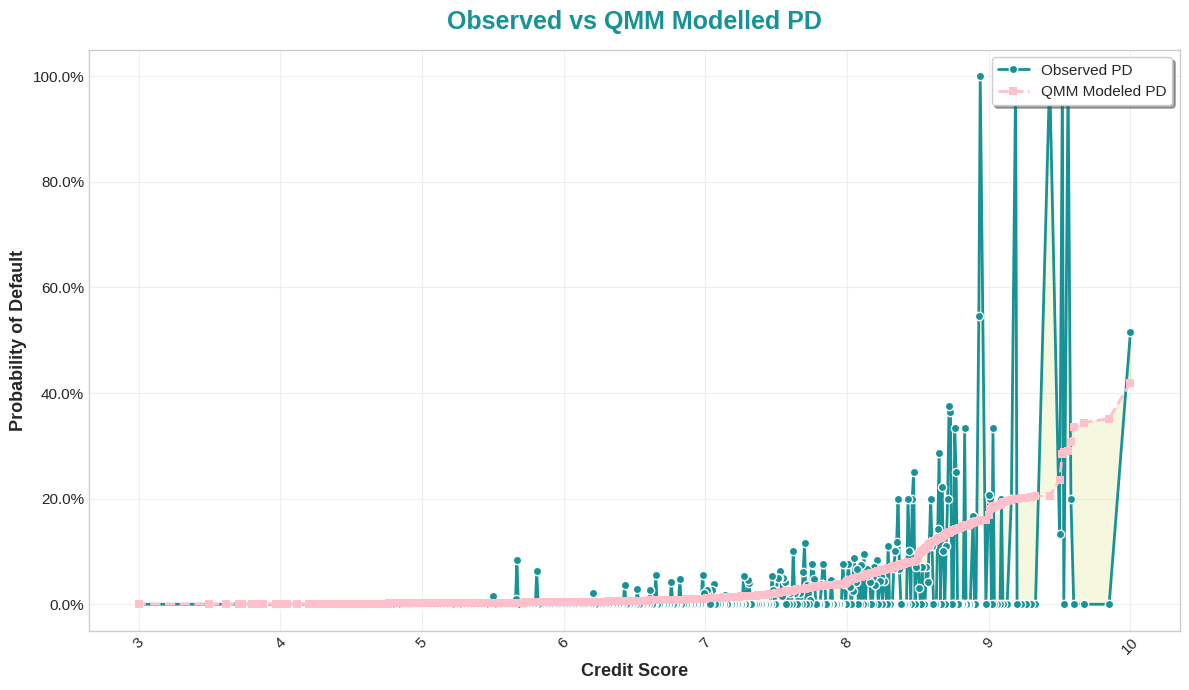



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 12817 entries, 0 to 19598
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 12817 non-null  int64  
 1   DTPOSICAO               12817 non-null  object 
 2   I_Est_Def12m_PES_FINAL  12817 non-null  int64  
 3   Rating_Final_Corrected  12817 non-null  object 
 4   Score_Corrected         10863 non-null  float64
 5   undrawn                 12817 non-null  object 
 6   R_ST                    12817 non-null  object 
 7   DES1                    12817 non-null  int64  
 8   DES2                    12817 non-null  int64  
 9   DES3                    12817 non-null  int64  
 10  DES4                    12817 non-null  int64  
 11  DES5                    12817 non-null  int64  
 12  DES6                    12817 non-null  object 
dtypes: float64(1), int64(7), obje

None


---------------------------------------------------------------

Rating_Final_Corrected Nº MISSINGS: 1954

Score_Corrected Nº MISSINGS: 1954


********************* RESULTS *******************************


Observed CT: 0.02366,    Target CT: 0.02722,    Diff: -0.004
Observed AR: 0.63013,    Target AR: 0.63013,    Diff: 0.000

-----------------------------------------------------------------

QMM model PD: 0.027218466738604858

Observed PD: 0.027218466738099318

Alpha: -4.37682159549658

Beta: -1.2773955132927826

Rating Model AR: 0.6301300710045215

QMM Model AR: 0.6301300710050064



**************** FINAL RESULTS **********************************



,n_obs,DR,QMM,DR_p,QMM_p
Rating_Final_Corrected,,,,,
MISSING,1954,0.059365,NaN,5.936540,NaN
a+,8,0.000000,0.000170,0.000000,0.016985
a-,19,0.000000,0.000294,0.000000,0.029442
b,1217,0.026294,0.031463,2.629417,3.146265
b+,2094,0.015759,0.018348,1.575931,1.834830
b-,940,0.044681,0.050150,4.468085,5.015050
bb,1539,0.004548,0.006265,0.454841,0.626483
bb+,1337,0.004488,0.003487,0.448766,0.348664
bb-,1638,0.010379,0.010397,1.037851,1.039697





################### CHALLENGE DES3 ##########################


/tmp/ipython-input-284357504.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:81: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  params = fsolve(tf, (0, 0))


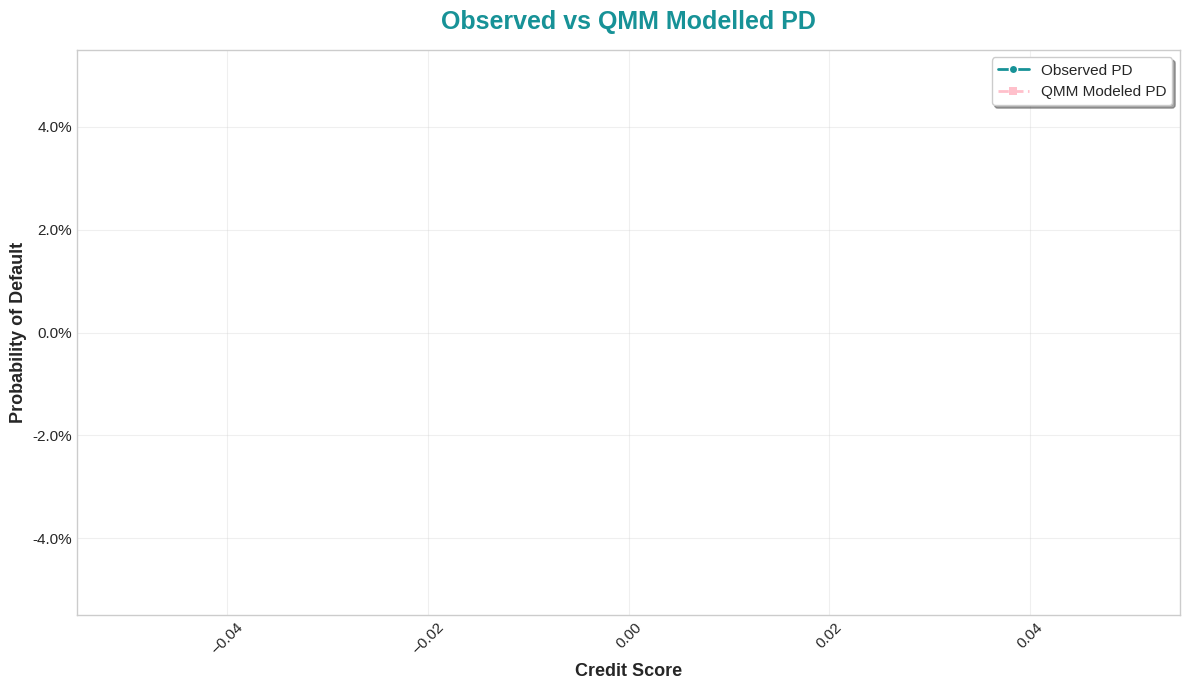



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 3663 entries, 6 to 19598
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 3663 non-null   int64  
 1   DTPOSICAO               3663 non-null   object 
 2   I_Est_Def12m_PES_FINAL  3663 non-null   int64  
 3   Rating_Final_Corrected  3663 non-null   object 
 4   Score_Corrected         0 non-null      float64
 5   undrawn                 3663 non-null   object 
 6   R_ST                    3663 non-null   object 
 7   DES1                    3663 non-null   int64  
 8   DES2                    3663 non-null   int64  
 9   DES3                    3663 non-null   int64  
 10  DES4                    3663 non-null   int64  
 11  DES5                    3663 non-null   int64  
 12  DES6                    3663 non-null   object 
dtypes: float64(1), int64(7), objec

None


---------------------------------------------------------------

Rating_Final_Corrected Nº MISSINGS: 3663

Score_Corrected Nº MISSINGS: 3663


********************* RESULTS *******************************


Observed CT: 0.00000,    Target CT: 0.03398,    Diff: -0.034
Observed AR: nan,    Target AR: nan,    Diff: nan

-----------------------------------------------------------------

QMM model PD: 0.0

Observed PD: 0.03398168996232998

Alpha: 0.0

Beta: 0.0

Rating Model AR: nan

QMM Model AR: nan



**************** FINAL RESULTS **********************************



,n_obs,DR,QMM,DR_p,QMM_p
Rating_Final_Corrected,,,,,
MISSING,3663,0.035217,NaN,3.521704,NaN





################### CHALLENGE DES4 ##########################


/tmp/ipython-input-284357504.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:81: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  params = fsolve(tf, (0, 0))


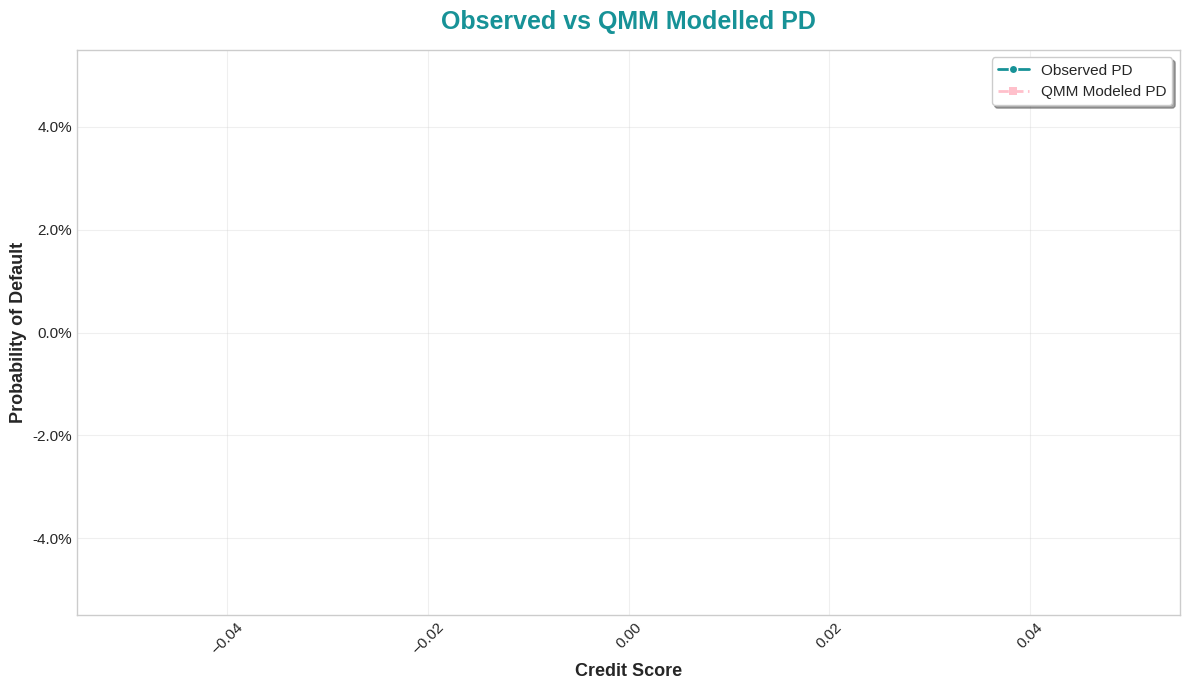



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 3243 entries, 6 to 19576
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 3243 non-null   int64  
 1   DTPOSICAO               3243 non-null   object 
 2   I_Est_Def12m_PES_FINAL  3243 non-null   int64  
 3   Rating_Final_Corrected  3243 non-null   object 
 4   Score_Corrected         0 non-null      float64
 5   undrawn                 3243 non-null   object 
 6   R_ST                    3243 non-null   object 
 7   DES1                    3243 non-null   int64  
 8   DES2                    3243 non-null   int64  
 9   DES3                    3243 non-null   int64  
 10  DES4                    3243 non-null   int64  
 11  DES5                    3243 non-null   int64  
 12  DES6                    3243 non-null   object 
dtypes: float64(1), int64(7), objec

None


---------------------------------------------------------------

Rating_Final_Corrected Nº MISSINGS: 3243

Score_Corrected Nº MISSINGS: 3243


********************* RESULTS *******************************


Observed CT: 0.00000,    Target CT: 0.02489,    Diff: -0.025
Observed AR: nan,    Target AR: nan,    Diff: nan

-----------------------------------------------------------------

QMM model PD: 0.0

Observed PD: 0.024894379024919863

Alpha: 0.0

Beta: 0.0

Rating Model AR: nan

QMM Model AR: nan



**************** FINAL RESULTS **********************************



,n_obs,DR,QMM,DR_p,QMM_p
Rating_Final_Corrected,,,,,
MISSING,3243,0.027752,NaN,2.775208,NaN





################### CHALLENGE DES5 ##########################


/tmp/ipython-input-284357504.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:81: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  params = fsolve(tf, (0, 0))


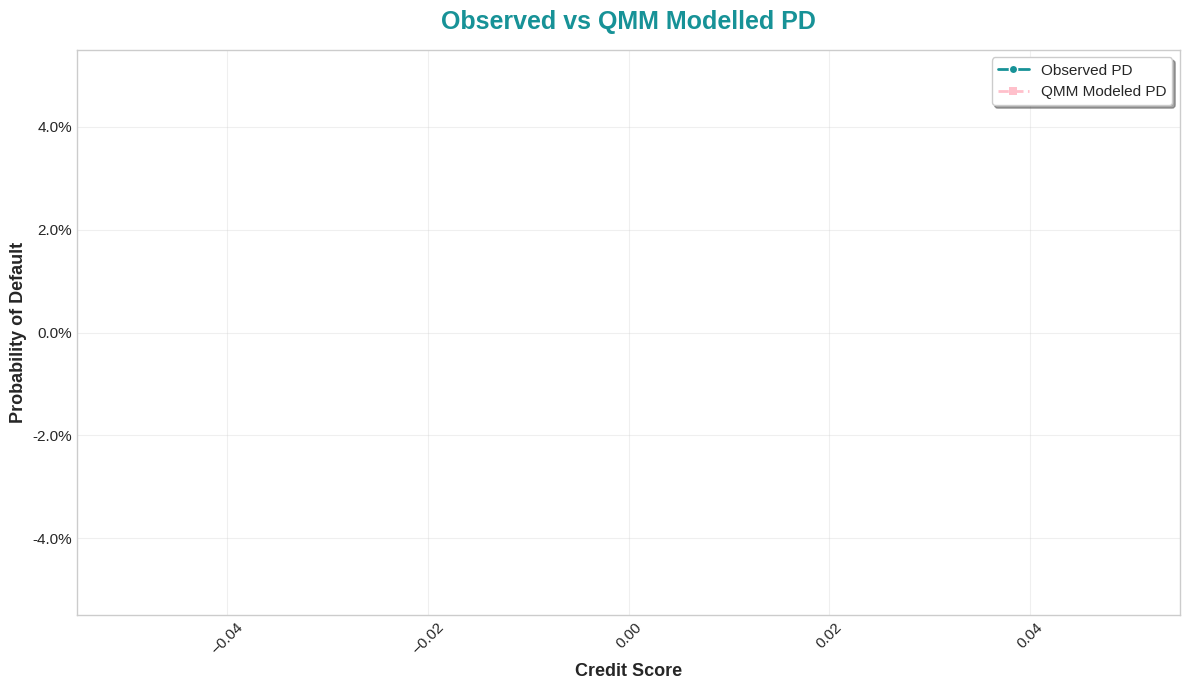



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 1954 entries, 30 to 19598
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 1954 non-null   int64  
 1   DTPOSICAO               1954 non-null   object 
 2   I_Est_Def12m_PES_FINAL  1954 non-null   int64  
 3   Rating_Final_Corrected  1954 non-null   object 
 4   Score_Corrected         0 non-null      float64
 5   undrawn                 1954 non-null   object 
 6   R_ST                    1954 non-null   object 
 7   DES1                    1954 non-null   int64  
 8   DES2                    1954 non-null   int64  
 9   DES3                    1954 non-null   int64  
 10  DES4                    1954 non-null   int64  
 11  DES5                    1954 non-null   int64  
 12  DES6                    1954 non-null   object 
dtypes: float64(1), int64(7), obje

None


---------------------------------------------------------------

Rating_Final_Corrected Nº MISSINGS: 1954

Score_Corrected Nº MISSINGS: 1954


********************* RESULTS *******************************


Observed CT: 0.00000,    Target CT: 0.05987,    Diff: -0.060
Observed AR: nan,    Target AR: nan,    Diff: nan

-----------------------------------------------------------------

QMM model PD: 0.0

Observed PD: 0.05986868899054298

Alpha: 0.0

Beta: 0.0

Rating Model AR: nan

QMM Model AR: nan



**************** FINAL RESULTS **********************************



,n_obs,DR,QMM,DR_p,QMM_p
Rating_Final_Corrected,,,,,
MISSING,1954,0.059365,NaN,5.93654,NaN





################### CHALLENGE DES6 ##########################


/tmp/ipython-input-284357504.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
/tmp/ipython-input-284357504.py:81: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  params = fsolve(tf, (0, 0))


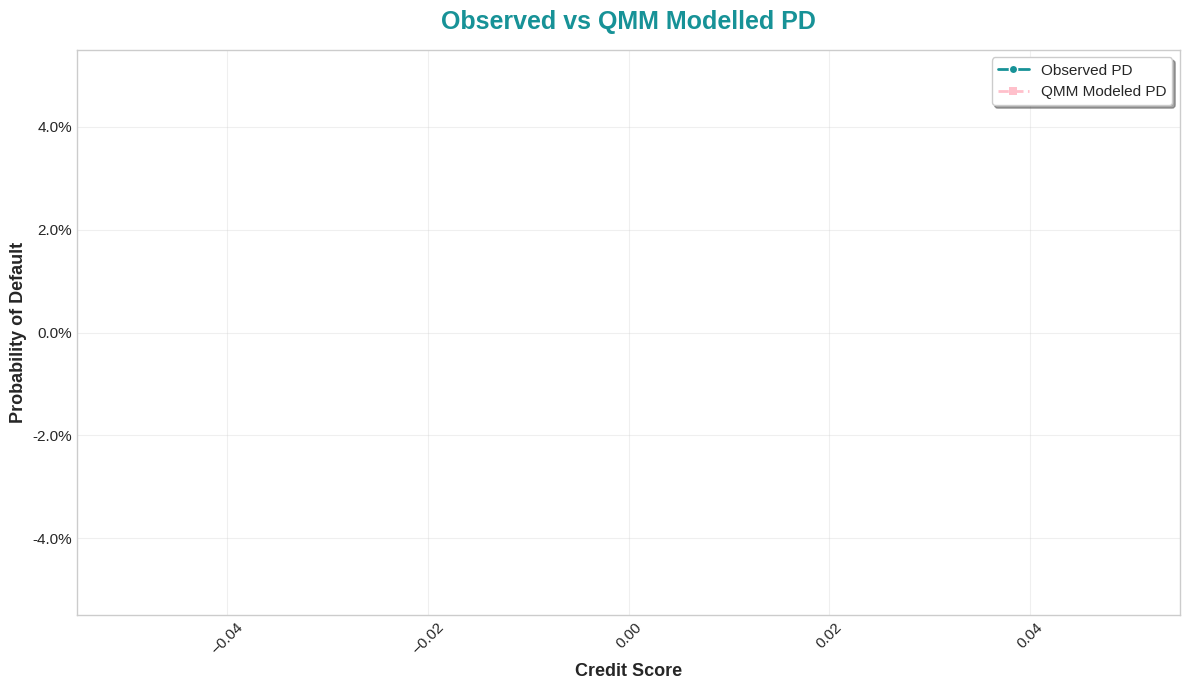



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 0 non-null      int64  
 1   DTPOSICAO               0 non-null      object 
 2   I_Est_Def12m_PES_FINAL  0 non-null      int64  
 3   Rating_Final_Corrected  0 non-null      object 
 4   Score_Corrected         0 non-null      float64
 5   undrawn                 0 non-null      object 
 6   R_ST                    0 non-null      object 
 7   DES1                    0 non-null      int64  
 8   DES2                    0 non-null      int64  
 9   DES3                    0 non-null      int64  
 10  DES4                    0 non-null      int64  
 11  DES5                    0 non-null      int64  
 12  DES6                    0 non-null      object 
dtypes: float64(1), int64(7), object(5)
memory usa

None


---------------------------------------------------------------

Rating_Final_Corrected Nº MISSINGS: 0

Score_Corrected Nº MISSINGS: 0


********************* RESULTS *******************************


Observed CT: 0.00000,    Target CT: nan,    Diff: nan
Observed AR: nan,    Target AR: nan,    Diff: nan

-----------------------------------------------------------------

QMM model PD: 0.0

Observed PD: nan

Alpha: 0.0

Beta: 0.0

Rating Model AR: nan

QMM Model AR: nan



**************** FINAL RESULTS **********************************



,n_obs,DR,QMM,DR_p,QMM_p
Rating_Final_Corrected,,,,,


In [10]:
# Lista dos desafios
desafios = [f"DES{i}" for i in range(1, 7)]

for d in desafios:
    print(f"\n\n\n################### CHALLENGE {d} ##########################")

    # Filtrar dados
    df_ch = df[df[d] == 1]

    # Calcular CT target (LRADR)
    LRA_DR = df_ch.groupby("Posicao").agg(
        DR=('I_Est_Def12m_PES_FINAL', 'mean'),
        count=('I_Est_Def12m_PES_FINAL', 'size')
    )["DR"].mean()

    # Rodar QMM
    # final file name, df_input, ct_target, ar_target
    qmm_results, results = run_QMM(f"QMM portfolio {d}", df_ch, LRA_DR, None)
